<a href="https://colab.research.google.com/github/SHDaniels/DSPS_sDaniels/blob/main/hw6_sdaniels/shar_DSPS_gaussian_process_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino

!pip install george
import george
from george import kernels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for george: filename=george-0.4.0-cp310-cp310-linux_x86_64.whl size=355559 sha256=d95e77b9183b1ff415f0135e6759dcbb9170e62b9ccc79372c1836d2f1b692a0
  Stored in directory: /root/.cache/pip/wheels/63/02/e3/24f2361717de09616769d97ed5854b4703d4df49fb1a3a1131
Successfully built george


# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [2]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [3]:
df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
57,2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
58,2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73
59,2009.0,24.39,25.53,25.48,25.84,24.95,24.09,23.09,22.03,21.48,21.64,21.99,23.21


In [4]:
df[df['YEAR']==1950.0].values[0,1]

23.11

In [5]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """
    time = np.zeros(732)
    data = np.zeros(732)
    month_float = 1/12
    for j, year in enumerate(df['YEAR']):
      for i in range(12):
        x = year + i*month_float
        time[12*j+i] = x
        y = df[df['YEAR']==year].values[0,1+i]
        data[12*j+i] = y
    return time, data




x, y = flatten_dataset(df)

# 1. Visualize

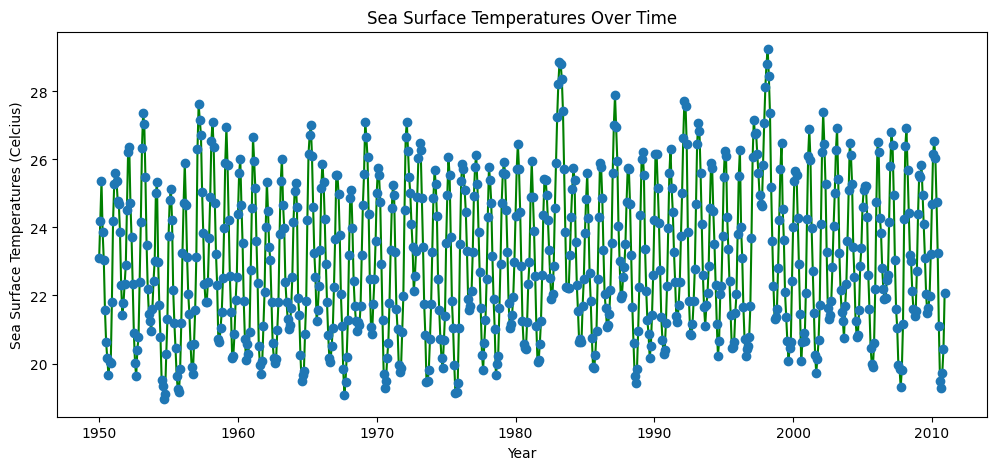

In [6]:
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    None
    """
    x, y = flatten_dataset(df)
    plt.figure(figsize=(12, 5))
    plt.plot(x, y, '-', color='green')
    plt.scatter(x, y, zorder=10)
    plt.title("Sea Surface Temperatures Over Time")
    plt.xlabel("Year")
    plt.ylabel("Sea Surface Temperatures (Celcius)")

visualize(df)

Figure 1. Here we can see the plot of sea surface temperature over time. We can see that the temperature changes in a rapid periodic manner (compared to the scale of our year axis), reflecting seasonal changes each year. Honestly, I know that the sea surface temperatures should be rising over time but this data is so noisy in its current format that it is hard to tell what the overall trends are.

# 2. Gaussian Process Regression (GPR)

In [7]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """
    times = np.zeros(29555)
    year = 1950
    counter = 0
    while year<2031:
      daysinyear = 365
      if year % 4 == 0:
        daysinyear = 366
      if year==2030:
        daysinyear = 365- 30 #subtracting the days in december that we dont want
      for day in range(daysinyear):
        t = year + (day/daysinyear)
        if year==2030:
          t = year + (day/365) #fixing that last year
        times[counter] = t
        counter+=1
      year+=1
    return times

t = get_interpolated_time()

In [8]:
t

array([1950.        , 1950.00273973, 1950.00547945, ..., 2030.90958904,
       2030.91232877, 2030.91506849])

In [9]:
def gaussian_process_regression(initial_guess, time, data, interp_time):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    pred, pred_var
    """
    scale, period, constant = initial_guess
    kernel = kernels.ExpSine2Kernel(scale, period) + kernels.ConstantKernel(constant)
    gp = george.GP(kernel, mean=np.mean(data))
    gp.compute(time)

    pred, pred_var = gp.predict(data, interp_time, return_var=True)
    # print(gp.get_parameter_dict())
    # print(gp.get_parameter_vector(include_frozen=True))
    return pred, pred_var

initial_guess =(1000, 4, .1)
pred, pred_var = gaussian_process_regression(initial_guess, x, y, t)

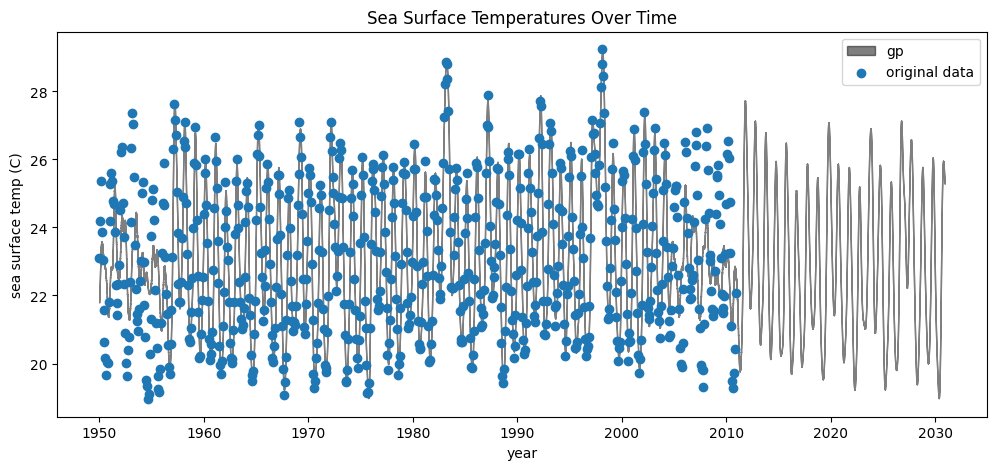

In [10]:
plt.figure(figsize=(12, 5))
plt.fill_between(t, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.5)
#plt.plot(t, pred, "k", lw=1.5, alpha=0.5)
plt.scatter(x, y)
#plt.plot(t, np.sin(t), "--g")
#plt.ylim(18,30)
plt.legend(["gp", "original data"])
plt.title("Sea Surface Temperatures Over Time")
plt.xlabel("year")
plt.ylabel("sea surface temp (C)");

Figure 2. This is a plot of our data as well as the gaussian process predictions for data points between and beyond the points that we have. It correctly predicts a sinusoidal motion, although the amplitude is too small for two sections of data points. Perhaps optimizing the parameters for our gaussian process will fix this!

# 3. Optimize

In [11]:
from scipy.optimize import minimize #sorry lol

In [12]:
def l2(args, x, y, t):
    '''l2 target function: returns value of l2 for given arguments and data for a model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    scale, period, constant = args
    pred, pred_var = gaussian_process_regression(args, x, y, t)
    # Create boolean masks for matching values within the tolerance
    matching_mask = np.isclose( x[:, None], t, rtol=0, atol=.5/365)

    #  Find the indices where matching values exist
    matching_indices = np.where(matching_mask)
    pred_small = pred[matching_indices[1][np.where(np.unique(matching_indices[0]))]]
    ynew = y[:-1]
    return sum((np.abs(ynew-pred_small))**2)




In [13]:
def optimize(params_initial_guess): #this takes ten minutes to run sorry
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.

    Print the results of your optimization.

    Parameters
    ----------
    ...

    Returns
    -------
    None
    """
    #we need a thing to minimize
    result = minimize(l2, params_initial_guess, args=(x, y, t))
    return result

params_initial_guess = initial_guess
result = optimize(params_initial_guess)

# 4. Visualize your model

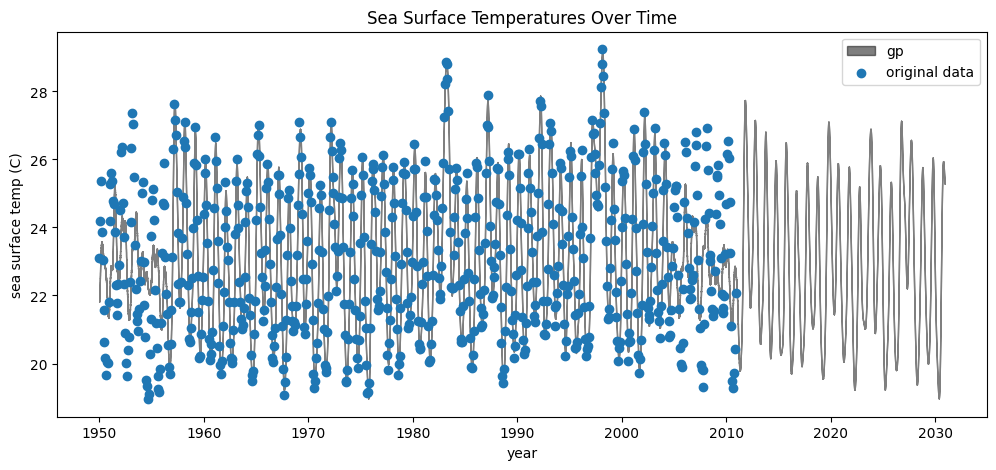

In [14]:
def visualize_model(args):
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    Parameters
    ----------


    Returns
    -------

    """
    pred, pred_var = gaussian_process_regression(args, x, y, t)
    plt.figure(figsize=(12, 5))
    plt.fill_between(t, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.5) #UNCERTAINTIES ARE HERE
    #plt.plot(t, pred, "k", lw=1.5, alpha=0.5)
    plt.scatter(x, y)
    #plt.plot(t, np.sin(t), "--g")
    #plt.ylim(18,30)
    plt.legend(["gp", "original data"])
    plt.title("Sea Surface Temperatures Over Time")
    plt.xlabel("year")
    plt.ylabel("sea surface temp (C)");

args = result.x
visualize_model(args)

Figure 3. This is a plot of our data as well as the gaussian process predictions for data points between and beyond the points that we have, this time with the parameters that we found with optimize. The fit looks similar to the fit from Figure 2 because the optimization did not change the parameters very much. It still misses some data points, but I like its prediction of new data. I chose a kernel with a sinusoidal motion plus a constant motion, because I expect the mean of the surface temperature to gradually increase (the constant kernel) as well as oscillating (the expsine kernel).

A note is that right now it plots the uncertainty range of the GP solution and not the points of the GP solution, but the uncertainties are so narrow on the scale of the graph that in practice the two plots would completely overlap.